
# Here I'm process by chunks the entire region.

In [34]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [35]:
from external_plugins.spystats import tools
%run ../testvariogram.py

In [36]:
section.shape

(1841, 46)

## Algorithm for processing Chunks
1. Make a partition given the extent
2. Produce a tuple (minx ,maxx,miny,maxy) for each element on the partition
3. Calculate the semivariogram for each chunk and save it in a dataframe
4. Plot Everything
5. Do the same with a mMatern Kernel

In [37]:
minx,maxx,miny,maxy = getExtent(new_data)

In [38]:
maxy

1556957.5046647713

In [39]:
## If prefered a fixed number of chunks
N = 100
xp,dx = np.linspace(minx,maxx,N,retstep=True)
yp,dy = np.linspace(miny,maxy,N,retstep=True)
### Distance interval
print(dx)
print(dy)

## Let's build the partition 
## If prefered a fixed size of chunk
ds = 300000 #step size (meters)
xp = np.arange(minx,maxx,step=ds)
yp = np.arange(miny,maxy,step=ds)
dx = ds
dy = ds
N = len(xp)


46465.4895488
28670.5754781


In [40]:
xx,yy = np.meshgrid(xp,yp)

In [41]:
Nx = xp.size
Ny = yp.size

In [42]:
#coordinates_list = [ (xx[i][j],yy[i][j]) for i in range(N) for j in range(N)]

coordinates_list = [ (xx[i][j],yy[i][j]) for i in range(Ny) for j in range(Nx)]


In [43]:
from functools import partial
tuples = map(lambda (x,y) : partial(getExtentFromPoint,x,y,step_sizex=dx,step_sizey=dy)(),coordinates_list)

In [44]:
chunks = map(lambda (mx,Mx,my,My) : subselectDataFrameByCoordinates(new_data,'newLon','newLat',mx,Mx,my,My),tuples)

In [45]:
## Here we can filter based on a threshold
threshold = 20
chunks_non_empty = filter(lambda df : df.shape[0] > threshold ,chunks)

In [46]:
len(chunks_non_empty)

91

In [47]:
lengths = pd.Series(map(lambda ch : ch.shape[0],chunks_non_empty))

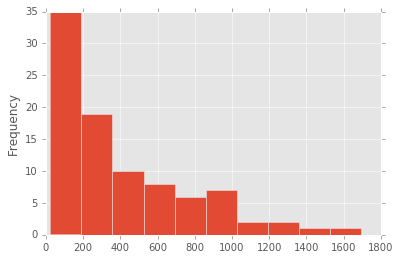

In [48]:
lengths.plot.hist()

### For efficiency purposes we restrict to 10 variograms

In [49]:
smaller_list = chunks_non_empty[:10]
variograms =map(lambda chunk : tools.Variogram(chunk,'residuals1',using_distance_threshold=200000),smaller_list)

In [50]:
vars = map(lambda v : v.calculateEmpirical(),variograms)
vars = map(lambda v : v.calculateEnvelope(num_iterations=50),variograms)

## Take an average of the empirical variograms also with the envelope. 
### We will use the group by directive on the field lags


In [51]:
envslow = pd.concat(map(lambda df : df[['envlow']],vars),axis=1)
envhigh = pd.concat(map(lambda df : df[['envhigh']],vars),axis=1)
variogram = pd.concat(map(lambda df : df[['variogram']],vars),axis=1)

In [52]:
lags = vars[0][['lags']]

In [53]:
meanlow = list(envslow.apply(lambda row : np.mean(row),axis=1))
meanhigh = list(envhigh.apply(np.mean,axis=1))
meanvariogram = list(variogram.apply(np.mean,axis=1))
results = pd.DataFrame({'meanvariogram':meanvariogram,'meanlow':meanlow,'meanhigh':meanhigh})

In [54]:
result_envelope = pd.concat([lags,results],axis=1)

In [55]:
meanvg = tools.Variogram(section,'residuals1')

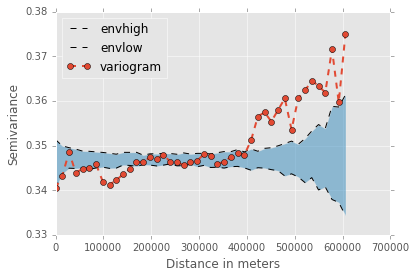

In [56]:
meanvg.plot()

In [57]:
meanvg.envelope.columns

Index([u'envhigh', u'envlow', u'lags', u'variogram'], dtype='object')

In [58]:
result_envelope.columns

Index([u'lags', u'meanhigh', u'meanlow', u'meanvariogram'], dtype='object')

In [59]:
result_envelope.columns = ['lags','envhigh','envlow','variogram']

In [60]:
meanvg.envelope = result_envelope

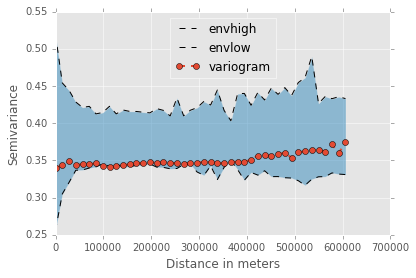

In [61]:
meanvg.plot(refresh=False)